**Importing libraries**

In [0]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
%matplotlib inline
np.random.seed(0)

**Download MNIST dataset**

In [0]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

**Tensor class which checks whether it takes an option of Autograd**

In [22]:
class Tensor (object):
    
    def __init__(self,data,
                 autograd=False,
                 creators=None,
                 creation_op=None,
                 id=None):
        
        self.data = np.array(data)
        self.autograd = autograd
        self.grad = None
        if(id is None):
            self.id = np.random.randint(0,100000)
        else:
            self.id = id
        
        self.creators = creators
        self.creation_op = creation_op
        self.children = {}
        
        if(creators is not None):
            for c in creators:
                if(self.id not in c.children):
                    c.children[self.id] = 1
                else:
                    c.children[self.id] += 1

    def all_children_grads_accounted_for(self):
        for id,cnt in self.children.items():
            if(cnt != 0):
                return False
        return True        
        
    def backward(self,grad=None, grad_origin=None):
        if(self.autograd):
            if(grad is None):
                grad = FloatTensor(np.ones_like(self.data))
            
            if(grad_origin is not None):
                if(self.children[grad_origin.id] == 0):
                    raise Exception("cannot backprop more than once")
                else:
                    self.children[grad_origin.id] -= 1

            if(self.grad is None):
                self.grad = grad
            else:
                self.grad += grad
            
            # grads must not have grads of their own
            assert grad.autograd == False
            
            # only continue backpropping if there's something to
            # backprop into and if all gradients (from children)
            # are accounted for override waiting for children if
            # "backprop" was called on this variable directly
            if(self.creators is not None and 
               (self.all_children_grads_accounted_for() or 
                grad_origin is None)):

                if(self.creation_op == "add"):
                    self.creators[0].backward(self.grad, self)
                    self.creators[1].backward(self.grad, self)
                    
                if(self.creation_op == "neg"):
                    self.creators[0].backward(self.grad.__neg__())
                    
    def __add__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data + other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="add")
        return Tensor(self.data + other.data)

    def __neg__(self):
        if(self.autograd):
            return Tensor(self.data * -1,
                          autograd=True,
                          creators=[self],
                          creation_op="neg")
        return Tensor(self.data * -1) 
    
    def __repr__(self):
        return str(self.data.__repr__())
    
    def __str__(self):
        return str(self.data.__str__())  
    
a = Tensor([1,2,3,4,5], autograd=True)
b = Tensor([2,2,2,2,2], autograd=True)
c = Tensor([5,4,3,2,1], autograd=True)

d = a + (-b)
e = (-b) + c
f = d + e

f.backward(Tensor(np.array([1,1,1,1,1])))

print(b.grad.data == np.array([-2,-2,-2,-2,-2]))

[ True  True  True  True  True]


**Data Exploration to show the Pixel Value Distribution**

Text(0.5, 1.0, 'Pixel Value Distribution')

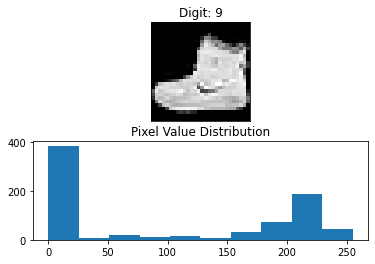

In [23]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.imshow(train_images[0], cmap='gray', interpolation='none')
plt.title("Digit: {}".format(train_labels[0]))
plt.xticks([])
plt.yticks([])
plt.subplot(2,1,2)
plt.hist(train_images[0].reshape(784))
plt.title("Pixel Value Distribution")

In [0]:
class Tensor:

    def __init__(self, data, requires_grad=False):
        self.data = data
        if not isinstance(data, np.ndarray):
            self.data = np.array(data)
        # whether to run backpropagation or not
        self.requires_grad = requires_grad
        # tensor gradient
        self._grad = None
        # operation if this tensor was used in it
        self._grad_fn = None

    @property
    def shape(self):
        return self.data.shape

    @property
    def grad_fn(self):
        if not self.requires_grad:
            raise Exception('This tensor is not backpropagated')
        return self._grad_fn

    @property
    def grad(self):
        return self._grad

    def backward(self, grad=None):
        if not self.grad_fn:
            return False

        if grad is None and self._grad is None:
            # in case if this is last loss tensor
            grad = self.__class__(1., requires_grad=False)

        elif self.grad is not None:
            grad = self._grad

        if not self.requires_grad:
            raise Exception('This tensor is not backpropagated')

        self.grad_fn.backward(grad)
        return True

    def __str__(self):
        return f'Tensor({str(self.data)})'

    def add_grad(self, grad):
        if self._grad is None:
            self._grad = grad
        else:
            self._grad += grad

    def __add__(self, o): 
        if self.data is not None:
            self.data += o.data  
            return self
        self.data = o.data 
        return self

In [0]:
class Op:

    def forward(self):
        raise NotImplemented

    def backward(self, grad):
        raise NotImplemented

    def __call__(self, *args):
        self.out = self.forward(*args)
        self.out._grad_fn = self
        return self.out

**Addition**

In [0]:
class AddOp(Op):

    '''Sumation operation with 2 tensors'''

    def forward(self, x: Tensor, y: Tensor):
        self.x = x
        self.y = y
        # created tensor should be backpropagated if at least one 
        # of the input is backpropagated
        requires_grad = x.requires_grad or y.requires_grad
        return Tensor(x.data + y.data, requires_grad=requires_grad)

In [0]:
def backward(self, grad):
        if self.x.requires_grad:
            # as we have matrix operation one of the parameters can 
            # have partial shape in such scenarion we need to sum
            # gradient values by missed axis
            if self.x.shape != grad.shape:
                axis = np.argmax(np.abs(np.array(self.x.shape) - 
                                 np.array(grad.shape)))
                self.x.add_grad(Tensor(grad.data.sum(axis=axis, 
                                                keepdims=True)))
            else:
                self.x.add_grad(grad)
            if self.x.grad_fn:
                self.x.backward()
        if self.y.requires_grad:
            if self.y.shape != grad.shape:
                axis = np.argmax(np.abs(np.array(self.y.shape) - 
                                        np.array(grad.shape)))
                self.y.add_grad(Tensor(grad.data.sum(axis=axis, 
                                                keepdims=True)))
            else:
                self.y.add_grad(grad)
            if self.y.grad_fn:
                self.y.backward()

**Multiplication**

In [0]:
class MulOp(Op):

    '''Multiplication operation with 2 tensors'''

    def forward(self, x: Tensor, y: Tensor):
        self.x = x
        self.y = y
        requires_grad = x.requires_grad or y.requires_grad
        return Tensor(x.data * y.data, requires_grad=requires_grad)

    def backward(self, grad):
        if self.x.requires_grad:
            print(self.x, self.x._grad, grad)
            self.x.add_grad(Tensor(grad.data * self.y.data, False))
            if self.x.grad_fn:
                self.x.backward()
        if self.y.requires_grad:
            self.y.add_grad(Tensor(grad.data * self.x.data, False))
            if self.y.grad_fn:
                self.y.backward()

**Testing the operations**

In [33]:
x = np.random.random((3,3))
a = np.random.random((3,3))
b = np.random.random((3,))

loss = np.random.random((3,3))

_x = Tensor(x,requires_grad=True)
_a = Tensor(a,requires_grad=True)
_b = Tensor(b,requires_grad=True)

# here we use parameter _a 2 times in different operations.
# that means that gradient will be calculated twice for _a.
# and thus we need to sum two gradients to get result 
# gradient for _a
y = MulOp()(AddOp()(MulOp()(_x, _a), _b), _a)
print('y = ', y)
print()
print('y.grad_fn = ', y.grad_fn)
print()
print('_x.grad = ',_x.grad)
print()
print('_a.grad = ',_a.grad) 
print()
print('_b.grad = ',_b.grad) 
print()
print('y.grad = ',y.grad)

y =  Tensor([[0.73764753 0.31056322 0.39565326]
 [0.72277071 0.25420705 0.5827517 ]
 [0.08433795 0.63643641 0.19616623]])

y.grad_fn =  <__main__.MulOp object at 0x7f3529b110f0>

_x.grad =  None

_a.grad =  None

_b.grad =  None

y.grad =  None


**Derivative for each layer without using Autograd**

In [0]:
class Layer:

    def forward(self):
        raise NotImplemented

    def backward(self, grad):
        raise NotImplemented

    def __call__(self, *args):
        return self.forward(*args)

class Sigmoid:

    def forward(self,x):
        self.x = x   
        return 1/(1+np.exp(-x))

    def backward(self, grad):
        grad_input = self.x*(1-self.x) * grad
        return grad_input

class Relu(Layer):

    def forward(self,x):
        self.x = x
        return np.maximum(np.zeros_like(x), x)

    def backward(self, grad):
        grad_input = (self.x > 0) * grad
        return grad_input

class SoftmaxCrossentropyWithLogits(Layer):

    def forward(self, x, y):
        self.x = x
        self.y = y

        exps = np.exp(x) 
        self.softmax = exps / np.sum(exps, axis=-1, keepdims=True)

        logits = self.softmax[np.arange(x.shape[0]),y]
        log_likelihood = -np.log(logits)
        loss = np.sum(log_likelihood) / x.shape[0]
        return loss

    def backward(self, grad=None):
        batch = self.x.shape[0]
        grad = self.softmax
        grad[np.arange(batch),self.y] -= 1
        grad = grad/batch
        return grad

class MSE(Layer):

    def forward(self, x, y):
        self.x = x
        self.y = y
        return ((x - y)**2) / (self.x.shape[0]*2)

    def backward(self, grad=None):
        # 1/2n * Sum(xi-yi)**2 
        # dx = 1/2n * Sum( x**2 -2*x*y + y**2) 
        # dx  = (2x - 2y) / 2*n = (x - y) / n
        return (self.x - self.y) / self.x.shape[0]

class Linear(Layer):

    def __init__(self, input, output, lr=0.0001):
        self.A = 2*np.random.random((input, output)) - 1
        self.b = 2*np.random.random((output)) - 1
        self.lr = lr

    def forward(self, x):
        self.x = x
        return np.dot(x,self.A) + self.b

    def backward(self, grad):
        # d_layer / db = 1
        b_grad = grad.mean(axis=0)*self.x.shape[0]
        # d_layer / dA = x
        A_grad = np.dot(self.x.T, grad)
        # As this layer have somee weights we need to update them using 
        # gradient descent
        # compute df / dx = df / d_layer * d_layer / dx
        # df / d_layer == grad
        grad_input = np.dot(grad, self.A.T)

        self.A -= A_grad * self.lr
        self.b -= b_grad * self.lr

        return grad_input

**Showing Simple Point Interpolation**

In [37]:
class Model(Layer):

    def __init__(self, lr=0.0001):
        self.lr = lr
        self.layers = [
            Linear(3,15, lr=self.lr),
            Relu(),
            Linear(15,1, lr=self.lr)        
        ]

    def forward(self,x):
        for l in self.layers:
            x = l(x)
        return x

    def backward(self, grad):
        for l in self.layers[::-1]:
            grad = l.backward(grad)

        return grad

mm = Model()

def yf(x1,x2,x3):
    return np.array([2 * x1 + 3*x2 + 4*x3 + 5],dtype=np.float32)

loss = MSE()

for i in range(20000):
    x1 = np.random.random()*30
    x2 = np.random.random()*20
    x3 = np.random.random()*11
    y = mm(np.array([[x1,x2,x3]]))
    err = loss(y, yf(x1,x2,x3))

    yb = loss.backward()
    yb = mm.backward(yb)
    if i % 100 == 0:
        print(err)
        print('VAL Target:',yf(1,2,3), 'Res:',
              mm(np.array([[1,2,3]])), 'Loss:',
              loss(yf(1,2,3), mm(np.array([[1,2,3]]
        ))))
        print('---------')

[[7579.86167303]]
VAL Target: [25.] Res: [[0.70982514]] Loss: [[295.0062973]]
---------
[[74.54324397]]
VAL Target: [25.] Res: [[17.01896818]] Loss: [[31.84843447]]
---------
[[3.06808869]]
VAL Target: [25.] Res: [[19.55243708]] Loss: [[14.83797089]]
---------
[[2.04436402]]
VAL Target: [25.] Res: [[20.71226582]] Loss: [[9.1923322]]
---------
[[4.03403528]]
VAL Target: [25.] Res: [[21.06258336]] Loss: [[7.75162488]]
---------
[[7.7981467]]
VAL Target: [25.] Res: [[21.71442899]] Loss: [[5.39748842]]
---------
[[0.30213948]]
VAL Target: [25.] Res: [[21.53805529]] Loss: [[5.99253057]]
---------
[[0.6814674]]
VAL Target: [25.] Res: [[21.75372949]] Loss: [[5.26913612]]
---------
[[0.69022666]]
VAL Target: [25.] Res: [[21.53833248]] Loss: [[5.99157101]]
---------
[[0.46918415]]
VAL Target: [25.] Res: [[21.69342614]] Loss: [[5.46671535]]
---------
[[1.11998351]]
VAL Target: [25.] Res: [[21.63959962]] Loss: [[5.64614536]]
---------
[[3.05645647]]
VAL Target: [25.] Res: [[21.84811263]] Loss: [[

**Classifying MNIST**

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw
Processing...
Done!
1.8783419375663168
---------
144.65022197321971
---------
135.02588893987186
---------
105.79693069534598
---------
96.41652205023132
---------
99.06045556856309
---------
100.08115192936954
---------
87.07959792219506
---------
104.84230767922978
---------
74.32142369509478
---------
83.92924872128873
---------
87.06386817009341
---------
88.91094802124532
---------
81.99828077392361
---------
70.73672401500424
---------
71.95186321672692
---------
77.5911462292614
---------
74.81981945453757
---------
60.61373035103805
---------
71.65601810337127
---------
62.10289921398613
---------
71.99077955051798
---------
69.66612025342577
---------
62.7024602807188
---------
77.26118557921214
---------
69.6002575482497
---------
57.788453845837864
---------
55.2524842596019
---------
56.87896403821705
---------
63.33385263041491
---------
59.34360488035738
---------
52.94564247547871
---------
56.15

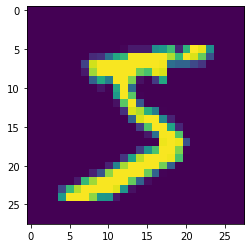

target: 5 predicted: 5


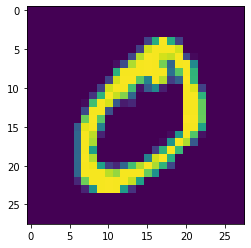

target: 0 predicted: 0


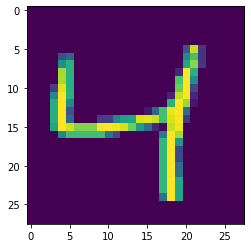

target: 4 predicted: 9


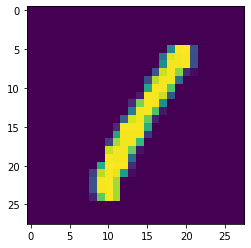

target: 1 predicted: 1


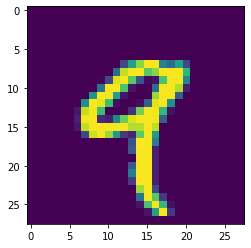

target: 9 predicted: 9


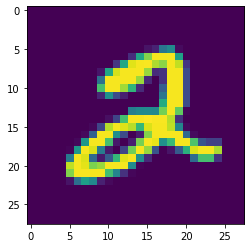

target: 2 predicted: 2


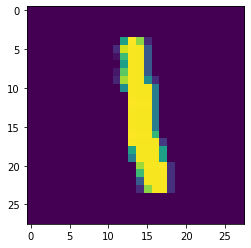

target: 1 predicted: 1


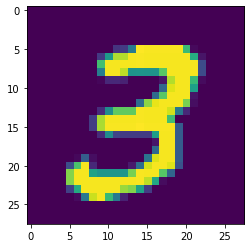

target: 3 predicted: 3


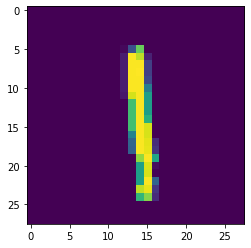

target: 1 predicted: 1


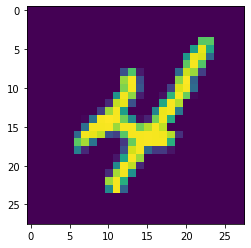

target: 4 predicted: 4


In [38]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

class Model(Layer):

    def __init__(self, lr=0.00001):
        self.lr = lr
        self.layers = [
            Linear(784,100, lr=self.lr),
            Relu(),
            Linear(100,200, lr=self.lr),
            Relu(),
            Linear(200,10, lr=self.lr)        
        ]

    def forward(self,x):
        for l in self.layers:
            x = l(x)
        return x

    def backward(self, grad):
        for l in self.layers[::-1]:
            grad = l.backward(grad)

        return grad


simple = transforms.Compose([
    transforms.ToTensor(), # converts to [0,1] interval
])
ds = MNIST('./mnist', download=True, transform=simple)
ld = DataLoader(ds, batch_size=2, pin_memory=True, drop_last=True) 

mm = Model()
loss = SoftmaxCrossentropyWithLogits()
_loss_avg = 0 
for e in range(5):
    for i, (img, label) in enumerate(ld):
        x = img.view(2,-1).numpy()

        res = mm(x)
        _loss = loss(res, label.numpy())
        _loss_avg += _loss.mean() # running loss mean
        grad = loss.backward(1)
        mm.backward(grad)

        if i % 100 == 0:
            print(_loss_avg/100)
            _loss_avg = 0
            print('---------')
            
for i in range(10):
    img, target = ds[i]
    plt.imshow(img[0])
    plt.show()
    x = img.view(1,-1).numpy()
    res = mm(x)[0]
    pred = np.argmax(res)
    print(f'target: {target} predicted: {pred}' )